In [1]:
%load_ext autoreload
%autoreload 2

# Training multiple Learner with Random Sampling

**Author:** [kkahloots](https://www.linkedin.com/in/kkahloots/)<br>
**Date created:** 2020/11/08<br>
**Last modified:** 2020/11/08<br>
**Description:** Performing learning as tasks by multiple learners.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


## Algorithm Setup 


In [3]:
image_size = (180, 180, 3)
batch_size = 36
n_learner=100
n_classes=2
validation_percentage=0.2
sample_percentage=0.3
valid_format = 'jpg'
image_dir = "data/PetImages/train"
holdout_dir = 'data/PetImages/holdout'
epochs = 20 #int(1e9)

In [4]:
from generators.from_images.file_image_generator import make_image_lists, get_generators
from builder.learner_building import make_learner
from tensorflow_addons.optimizers import RectifiedAdam
from livelossplot import PlotLossesKeras

In [5]:
loss_fn = tf.losses.binary_crossentropy
metrics=[tf.metrics.Accuracy()]

## Training Loop 


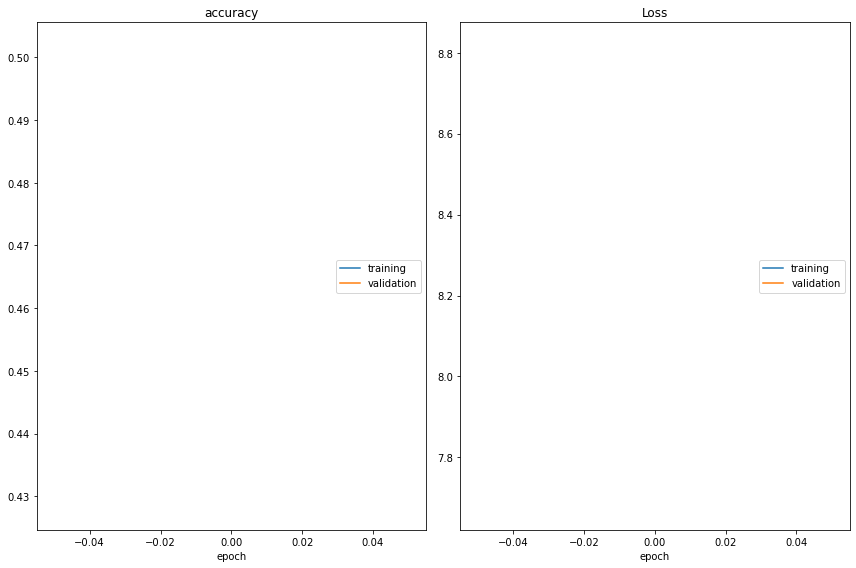

accuracy
	training         	 (min:    0.502, max:    0.502, cur:    0.502)
	validation       	 (min:    0.428, max:    0.428, cur:    0.428)
Loss
	training         	 (min:    7.678, max:    7.678, cur:    7.678)
	validation       	 (min:    8.818, max:    8.818, cur:    8.818)
500/500 [==============================] - 241s 481ms/step - loss: 7.6782 - accuracy: 0.5019 - val_loss: 8.8179 - val_accuracy: 0.4283
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 7.6765 - accuracy: 0.5023

In [ ]:
for learner_id in range(n_learner):
    imgs_list = make_image_lists(
    image_dir=image_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format,
    sample_pct=sample_percentage
    )
    
    train_generator, validation_generator = \
                                    get_generators(
                                                    images_list=imgs_list, 
                                                    image_dir=image_dir,
                                                    holdout_dir=None,
                                                    holdout_list=None,
                                                    image_size=image_size, 
                                                    batch_size=batch_size, 
                                                    class_mode='binary' if n_classes==2 else 'categorical',
                                                    rotation_range=40,
                                                    width_shift_range=0.2,
                                                    height_shift_range=0.2,
                                                    shear_range=0.2,
                                                    zoom_range=0.2,
                                                    horizontal_flip=True,
                                                    fill_mode='nearest',
                                                    return_filename=False
                                                                    )
    
    train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types= (tf.float32, tf.float32)
    )

    val_ds = tf.data.Dataset.from_generator(
    lambda: validation_generator, 
    output_types= (tf.float32, tf.float32)
    )
    
    
    learner = make_learner(model_name=f'learner{learner_id}', input_shape=image_size, num_classes=n_classes)
    
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val-loss', 
    min_delta=1e-6, 
    patience=6, 
    verbose=1, 
    restore_best_weights=True
    )
    
    learner_sp = f"experiments/{learner.name}.hdf5"
    ms =  tf.keras.callbacks.ModelCheckpoint(filepath=learner_sp, 
                                            verbose=1, 
                                            save_best_only=True)
    

    callbacks = [es, ms, PlotLossesKeras()]

    learner.compile(
        optimizer=RectifiedAdam(),
        loss=loss_fn,
        metrics=metrics
    )

    learner.fit(
                x=train_ds, 
                epochs=epochs, 
                steps_per_epoch=500,
                callbacks=callbacks, 
                validation_data=val_ds, 
                validation_steps=500,
                workers=-1,
                use_multiprocessing=True,
                verbose=1
                )


In [ ]:
xxx

In [ ]:
holdout_list = make_image_lists(
    image_dir=holdout_dir, 
    validation_pct=0.0, 
    valid_imgae_formats=valid_format
)

## Evaluate the learner on training, validation and holdout dataset

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
learner = tf.keras.models.load_model(filepath=learner_sp, compile=False)

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
loss_fn = tf.losses.binary_crossentropy

In [ ]:
eval_epoch=10
momory_file = 'memory/learner_tracing.csv'
col_names = ['filename', 'learner', 'score']

In [ ]:
from memory.memory_manager import insert

In [ ]:
import pandas as pd

In [ ]:
memory_file = pd.DataFrame(columns=col_names)

In [ ]:
#insert(filename= filename[0].replace('\\', '/'), learner=learner.name, score=loss_value.numpy())

In [ ]:
for ep in tqdm(range(eval_epoch)):
    images, labels, filenames = next(train_generator)
    loss_values = loss_fn(labels, learner.predict(images))
    for filename, loss_value in zip(filenames.values(), loss_values):
        record = {'filename': filename[0].replace('\\', '/'), 'learner':learner.name, 'score': loss_value.numpy()}
        ix = 0 if pd.isnull(memory_file.index.max()) else memory_file.index.max()
        memory_file.loc[ix+1] = record.values()

In [ ]:
memory_file.head()

In [ ]:
e = '1'
memory_file.to_csv(f'memory/learner_tracing{e}.csv', index=False, mode='a')

In [ ]:
import pandas as pd
memory_file = pd.read_csv(filepath_or_buffer=momory_file, names=col_names)

In [ ]:
print(memory_file.shape)

In [ ]:
memory_file.head()

In [ ]:
files_score = memory_file.groupby(['filename', 'learner'])['score'].mean().to_frame().reset_index()


In [ ]:
files_score[files_score['filename'] =="data/PetImages/train/Cat/11206.jpg"]

In [ ]:
files_score['score'].min()

In [ ]:
def ds2itr(ds):
    while True:
        try:
            for data in ds:
                yield data
        except StopIteration as e:
            pass
        

In [ ]:
def take2(gen):
    while True:
        batch = next(gen)
        yield batch[0], batch[1]

In [ ]:
tf.data.Dataset.from_tensors

In [ ]:
train_ds = tf.data.Dataset.from_generator(
    lambda: take2(train_generator), 
    output_types= (tf.float32, tf.float32)
)

val_ds = tf.data.Dataset.from_generator(
    lambda: take2(validation_generator), 
    output_types= (tf.float32, tf.float32)
)

holdout_ds = tf.data.Dataset.from_generator(
    lambda: take2(holdout_generator), 
    output_types= (tf.float32, tf.float32)
)

In [ ]:
ds = ds2itr(train_ds)
train_loss_scores = {}
train_loss_score = []
for ep in tqdm(range(eval_epoch)):
    batch = next(ds)
    train_loss_value = loss_fn(batch[1], learner.predict(batch[0]) )
    train_loss_score += [train_loss_value]
train_loss_scores = {loss_fn.__name__: train_loss_score}   

train_loss_scores = {k: {'min': 
                          tf.math.reduce_min([*val][0], axis=0).numpy(), 
                          'max':
                          tf.math.reduce_max([*val][0], axis=0).numpy(), 
                          'std': 
                          tf.math.reduce_std([*val][0], axis=0).numpy(), 
                          'mean': 
                          tf.math.reduce_mean([*val][0], axis=0).numpy() } for k, val in train_loss_scores.items()} 


In [ ]:
ds = ds2itr(val_ds)
val_loss_scores = {}
val_loss_score = []
for ep in tqdm(range(eval_epoch)):
    batch = next(ds)
    val_loss_value = loss_fn(batch[1], learner.predict(batch[0]) )
    val_loss_score += [val_loss_value]
val_loss_scores = {loss_fn.__name__: val_loss_score}   

val_loss_scores = {k: {'min': 
                          tf.math.reduce_min([*val][0], axis=0).numpy(), 
                          'max':
                          tf.math.reduce_max([*val][0], axis=0).numpy(), 
                          'std': 
                          tf.math.reduce_std([*val][0], axis=0).numpy(), 
                          'mean': 
                          tf.math.reduce_mean([*val][0], axis=0).numpy() } for k, val in val_loss_scores.items()} 


In [ ]:
print('train loss', train_loss_scores)
print('val loss',val_loss_scores)

In [ ]:
decision = lambda x: 1 if x > 0.5 else 0

In [ ]:
ds = ds2itr(train_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    train_metric_scores = {}
    train_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        train_metric_value = metric_fn(batch[1], pred)
        train_metric_score += [train_metric_value]
    train_metric_scores = {metric: train_metric_score}   

    train_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in train_metric_scores.items()} 
   
    mertics_score.update(train_metric_scores)

In [ ]:
ds = ds2itr(val_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    val_metric_scores = {}
    val_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        val_metric_value = metric_fn(batch[1], pred)
        val_metric_score += [val_metric_value]
    val_metric_scores = {metric: val_metric_score}   

    val_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in val_metric_scores.items()} 
   
    mertics_score.update(val_metric_scores)

In [ ]:
ds = ds2itr(holdout_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    holdout_metric_scores = {}
    holdout_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        holdout_metric_value = metric_fn(batch[1], pred)
        holdout_metric_score += [holdout_metric_value]
    holdout_metric_scores = {metric: holdout_metric_score}   

    holdout_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in holdout_metric_scores.items()} 
   
    mertics_score.update(holdout_metric_scores)

In [ ]:
print('train metric', train_metric_scores)
print('val metric',val_metric_scores)
print('holdout metric', holdout_metric_scores)

## Visualize the last layer

In [ ]:
learner = tf.keras.models.load_model(filepath=learner_sp, compile=False)

In [ ]:
learner.summary()

In [ ]:
learner.layers[-3]

In [ ]:
image_size

In [ ]:
x = tf.keras.layers.Reshape(image_size)(learner.layers[-3].output)

In [ ]:
model2 = tf.keras.Model(inputs=learner.inputs, outputs=[x])
model2.summary()

In [ ]:
ds = ds2itr(val_ds)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
images = next(ds)[0]

In [ ]:
images.shape

In [ ]:
Image.fromarray((images[0].numpy()* 255.0).astype(np.uint8), mode='RGB')

In [ ]:
predictions = model2.predict(images)

In [ ]:
Image.fromarray((predictions[0] * 255.0).astype(np.uint8), mode='RGB')

In [ ]:
from utils.reporting.ploting import plot_and_save_generated

In [ ]:
plot_and_save_generated(images.numpy(), epoch=999, path='.', gray=False, save=False)

In [ ]:
plot_and_save_generated( [Image.fromarray((img * 255.0).astype(np.uint8), mode='RGB') for img in predictions], epoch=999, path='.', gray=False, save=False)